In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn
import torchvision.transforms.functional as TF

import datasets, custom_transforms, RajaramanModel, pytorch_msssim
#import lungSegFunctions as LF

# Flags:
flag_saveReportPictures = True # set to True to produce a batch of example images for writing reports and papers
flag_saveSuppressedImages = True # set to True to produce images for further AI training
flag_cropping=False # if True -- use lung segmentation to generate a bounding box to crop the CXR image
flag_bone_suppression=True # if True, activate bone suppression

# Paths
PATH_SAVE_NETWORK_INTERMEDIATE = "./runs/Rajaraman_ResNet/177-20-20/10KFold/network_intermediate_5.tar"
key_source = "source" # this is the dictionary key for the original radiograph in the datasets
key_boneless = "boneless" # this is the dictionary key for the bone-suppressed radiograph in the datasets file

# Data
_batch_size = 8
crop_image_spatial_size = (256,256)
interp_mode = TF.InterpolationMode.NEAREST #BILINEAR

switch = "internal_test" # "QEH_onePerPatient_all"  # "JSRT_all" #    "JSRT_NN" # # #"Dongrong_Test"

if flag_cropping:
    desc_crop = "_cropped"
else:
    desc_crop = "_uncropped"
if flag_bone_suppression:
    save_description = "_suppressed_10KFold"+desc_crop
else:
    save_description = "_noSuppression_10KFold_"+desc_crop

    
    
    
print("The dataset chosen is: " + switch)
def transform_dataset(keys_images):
    transforms = tvtransforms.Compose([
                                custom_transforms.ToTensor(keys_images),
                                custom_transforms.Resize(keys_images, crop_image_spatial_size , interp_mode), 
                                 ])
    return transforms
if switch == "JSRT_all":
    directory_source = "D:/data/JSRT/JSRT/"
    directory_boneless = "D:/data/JSRT/BSE_JSRT/"
    keys_images = [key_source, key_boneless]
    ds = datasets.JSRT_CXR(directory_source, directory_boneless, 
                           transform=transform_dataset(keys_images))
elif switch == "internal_test":
    directory_source = "G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/test/normal/"
    directory_boneless = "G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/test/suppressed/"
    keys_images = [key_source, key_boneless]
    ds = datasets.JSRT_CXR(directory_source, directory_boneless, 
                           transform=transform_dataset(keys_images))
elif switch == "JSRT_NN":
    directory_source = "D:/data/JSRT/JSRT_NN/"
    directory_boneless = None
    keys_images = [key_source]
    ds = datasets.JSRT_CXR(directory_source, directory_boneless, 
                           transform=transform_dataset(keys_images))
elif switch == "QEH_full":
    externalTest_directory = r"D:/data/QEH_COVID19_DATASET/CXR_pngs/"
    keys_images = [key_source]
    ds = datasets.POLYU_COVID19_CXR_CT_Cohort1(externalTest_directory,
                                 transform=transform_dataset(keys_images))
elif switch == "QEH_onePerPatient_all":
    externalTest_directory = r"D:/data/QEH_COVID19_DATASET/QEH_Earliest_CXR_per_patient/all/"
    keys_images = [key_source]
    ds = datasets.POLYU_COVID19_CXR_CT_Cohort1(externalTest_directory,
                                 transform=transform_dataset(keys_images))
elif switch == "QEH_onePerPatient_HQ":
    externalTest_directory = r"D:/data/QEH_COVID19_DATASET/QEH_Earliest_CXR_per_patient/high_quality/"
    keys_images = [key_source]
    ds = datasets.POLYU_COVID19_CXR_CT_Cohort1(externalTest_directory,
                                 transform=transform_dataset(keys_images))
elif switch =="Dongrong_Test":
    normal_path = "D:/data/DongrongDataSets/test/NORMAL"
    pneumonia_path = "D:/data/DongrongDataSets/test/PNEUMONIA/"
    covid_path = "D:/data/DongrongDataSets/test/COVID/"
    keys_images = [key_source]
    ds = datasets.DongrongCOVIDDataset(normal_path, pneumonia_path, covid_path, 
                                       transform=transform_dataset(keys_images))
elif switch == "Yuhua_DDR":
    external_test_file = "D:/data/Yuhua_DDR/DDR_frames.npy"
    keys_images = [key_source]
    ds = datasets.Yuhua_DDR( external_test_file, transform=tvtransforms.Compose([custom_transforms.ToTensor(keys_images)]))
    #plt.imshow(next(iter(ds))[key_source][0,:])
else:
    raise RuntimeError("Dataset unknown.  Please input the details in the datasets.py file")
print(len(ds))
dl = DataLoader(ds, _batch_size, shuffle=False, num_workers=0)

# Select test 
sample = next(iter(dl))
print(sample[key_source].shape)

## Code for putting things on the GPU
ngpu = 1 #torch.cuda.device_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

The dataset chosen is: internal_test
20
torch.Size([8, 1, 256, 256])
cuda
GeForce RTX 2080 Ti


In [2]:
# Network
input_array_size = (_batch_size, 1, crop_image_spatial_size[0], crop_image_spatial_size[1])
net = RajaramanModel.ResNet_BS(input_array_size)
#net = nn.DataParallel(net, list(range(ngpu)))
if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
    print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
    checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE, map_location='cpu')
    start_epoch = checkpoint['epoch_next']
    reals_shown_now = checkpoint['reals_shown']
    net.load_state_dict(checkpoint['model_state_dict'])
    print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                        start_epoch, reals_shown_now))
else:
    print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
    raise RuntimeError("No checkpoint found at specified path.")

net = net.to(device)
# Set to testing mode
net.eval()
print(".")


=> loading checkpoint './runs/Rajaraman_ResNet/177-20-20/10KFold/network_intermediate_5.tar'
=> loaded checkpoint './runs/Rajaraman_ResNet/177-20-20/10KFold/network_intermediate_5.tar' (epoch 200, reals shown 35600)
.


In [3]:
# Lung Segmentation Network
if flag_cropping:
    LS = LF.LungSegmentationNetwork(device)

    def cropImage(input_minibatch, boneless_minibatch, flag_cropping, image_spatial_size, interp_mode):
        if not flag_cropping:
            return input_minibatch, boneless_minibatch
        else:
            # lung segment first
            mask, image = LS.segment(input_minibatch)
            mask = mask.cpu() ; image = image.cpu();
            torchresize = tvtransforms.Resize(image_spatial_size, interp_mode)

            # Crop
            inputImage = LS.crop(image, mask, image_spatial_size, interp_mode )
            if boneless_minibatch is not None:
                boneless = LS.crop(boneless_minibatch, mask, image_spatial_size, interp_mode)
            else:
                boneless = boneless_minibatch
            return inputImage, boneless

./runs/Rajaraman_ResNet/177-20-20/10KFold


<Figure size 432x288 with 0 Axes>

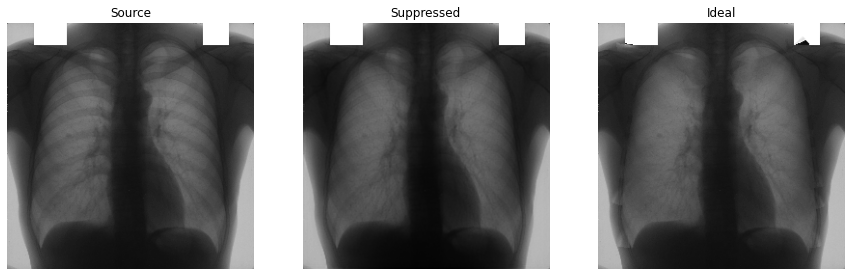

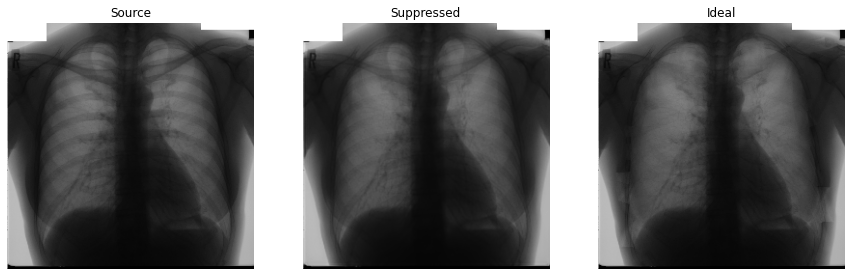

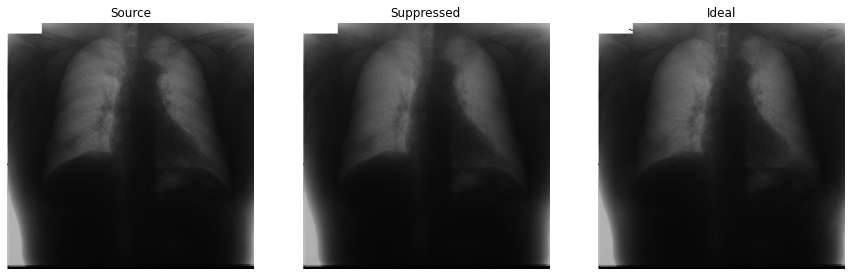

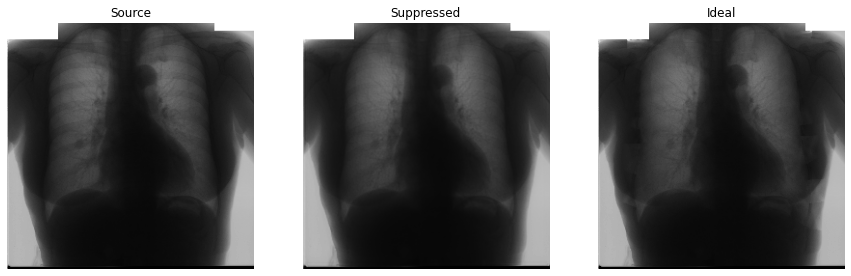

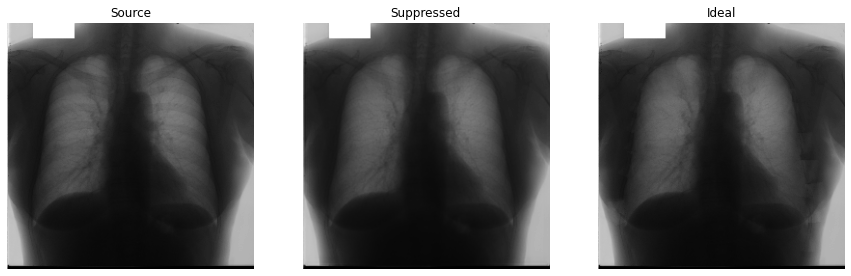

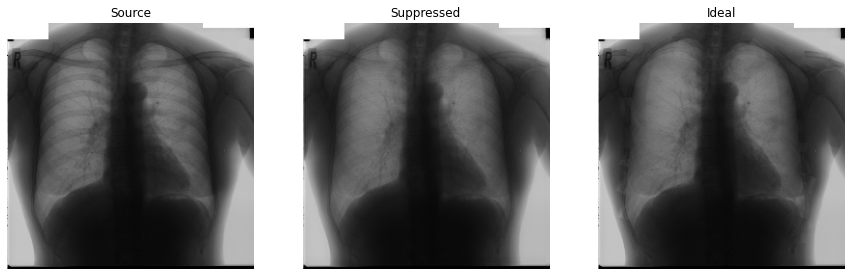

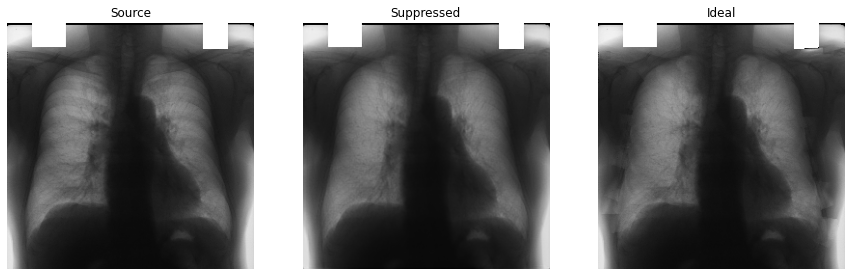

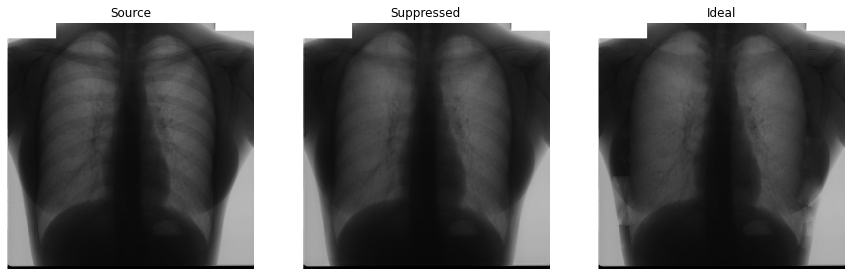

In [4]:
# Display
save_directory = os.path.split(PATH_SAVE_NETWORK_INTERMEDIATE)[0]
print(save_directory)

with torch.no_grad():
    # crop processing
    if flag_cropping:
        if key_boneless in keys_images:
            inputImage, croppedBoneless = cropImage(sample[key_source], sample[key_boneless], flag_cropping, crop_image_spatial_size, interp_mode)
        else:
            inputImage, croppedBoneless = cropImage(sample[key_source], None, flag_cropping, crop_image_spatial_size, interp_mode)
    else:
        inputImage = sample[key_source]

    # Suppress
    if flag_bone_suppression:
        inputImage = inputImage.to(device)
        out = net(inputImage)
        out = out.detach()
    else:
        out = inputImage.detach().clone()


# Enter variables
image = inputImage.cpu()
out = out.cpu()
if key_boneless in keys_images:
    if flag_cropping:
        boneless = croppedBoneless.cpu()
    else:
        boneless = sample[key_boneless].cpu()
    
for batch_idx in range(sample[key_source].shape[0]):
    if key_boneless in keys_images:
        plt.figure(1)
        fig, ax = plt.subplots(1,3, figsize=(15,5))
        ax[0].imshow(image[batch_idx,0,:],cmap='gray')
        ax[0].set_title("Source")
        ax[0].axis("off")
        ax[1].imshow(out[batch_idx,0,:],cmap='gray')
        ax[1].set_title("Suppressed")
        ax[1].axis("off")
        ax[2].imshow(boneless[batch_idx,0,:],cmap='gray')
        ax[2].set_title("Ideal")
        ax[2].axis("off")
    else:
        plt.figure(1)
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].imshow(image[batch_idx,0,:],cmap='gray')
        ax[0].set_title("Source")
        ax[0].axis("off")
        ax[1].imshow(out[batch_idx,0,:],cmap='gray')
        ax[1].set_title("Suppressed")
        ax[1].axis("off")
    if flag_saveReportPictures:
        plt.savefig(os.path.join(save_directory, switch + "_comparisonImages_"+ str(batch_idx) +".png"))

In [5]:
if flag_saveSuppressedImages:
    print("Saving a set of bone suppressed images")
    path_to_save_images = Path(os.path.join("bone_suppressed",switch+save_description))
    path_to_save_images.mkdir(parents=True, exist_ok=True)
    print(path_to_save_images)
    iters=0
    for ii, data in enumerate(dl):
        with torch.no_grad():
            input_data = data[key_source]
            
            # crop processing
            if key_boneless in keys_images:
                inputImage, croppedBoneless = cropImage(input_data, sample[key_boneless], flag_cropping, crop_image_spatial_size, interp_mode)
            else:
                inputImage, croppedBoneless = cropImage(input_data, None, flag_cropping, crop_image_spatial_size, interp_mode)

            # Suppress
            if flag_bone_suppression:
                inputImage = inputImage.to(device)
                out = net(inputImage)
                out = out.detach()
            else:
                out = inputImage.detach().clone()
            
            out = out.cpu()
            print("Batch Number:" + str(ii))
        
        # Save Images
        for iii, image in enumerate(out):
            try:
                savename = data["Patient"][iii]+".png"
            except:
                savename = str(iters)+".png"
            if switch == "Yuhua_DDR":
                # flip the image back vertically
                image = tvtransforms.functional.vflip(image)
            vutils.save_image( image, os.path.join(path_to_save_images, savename))
            iters+=1
    print("Complete saving suppressed images")
else:
    print("Don't save suppressed images.")

Saving a set of bone suppressed images
bone_suppressed\internal_test_suppressed_10KFold_uncropped


NameError: name 'cropImage' is not defined

In [ ]:
# Analysis
def PSNR(image, reference, max_reference=1.):
    """ 
    Peak Signal-to-Noise Ratio
    Input image and reference assumed to be Torch Tensors of shape [NxCxHxW]
    """
    # Assume the image 
    H = image.size(-2)
    W = image.size(-1)
    MSE = (1/(H*W))*torch.sum((torch.abs(image - reference))**2, (-1,-2))
    rtMSE = torch.sqrt(MSE)
    
    output = 20*torch.log10(max_reference/rtMSE)
    return np.atleast_1d(output.numpy().squeeze())

def NPS():
    """Noise Power Spectrum"""
    pass

def SSIM(image, reference):
    iters = 0
    out_list = np.ndarray(image.size(0))
    for im in image:
        im = im.numpy()
        im = np.moveaxis(im, 0,-1)
        ref = reference[iters,:].numpy()
        ref = np.moveaxis(ref, 0,-1)
        out = skimage.metrics.structural_similarity(im, ref, multichannel=True)
        out_list[iters]=out
        iters+=1
    return np.atleast_1d(out_list)

def RMSE(image, reference):
    # Assume the image 
    H = image.size(-2)
    W = image.size(-1)
    MSE = (1/(H*W))*torch.sum((torch.abs(image - reference))**2, (-1,-2))
    RMSE = torch.sqrt(MSE)
    out_list = np.squeeze(RMSE.numpy())
    return np.atleast_1d(out_list)

if "test" in switch:
    psnr_dict={"source_to_boneless":[], "suppressed_to_boneless":[]}
    ssim_dict={"source_to_boneless":[], "suppressed_to_boneless":[]}
    RMSE_dict ={"source_to_boneless":[], "suppressed_to_boneless":[]}
    if key_boneless in keys_images:
        for sample in dl:
            with torch.no_grad():
                if flag_cropping:
                    # crop processing
                    inputImage, croppedBoneless = cropImage(sample[key_source], sample[key_boneless], flag_cropping, crop_image_spatial_size, interp_mode)
                else:
                    inputImage, croppedBoneless = sample[key_source], sample[key_boneless]

                # Suppress
                if flag_bone_suppression:
                    inputImage = inputImage.to(device)
                    out = net(inputImage)
                    out = out.detach()
                else:
                    out = inputImage.detach().clone()

                # Enter variables
                image = inputImage.cpu()
                out = out.cpu()
                boneless = croppedBoneless.cpu()

            psnr_dict["source_to_boneless"].append(PSNR(image, boneless))
            psnr_dict["suppressed_to_boneless"].append(PSNR(out, boneless))
            ssim_dict["source_to_boneless"].append(SSIM(image, boneless))
            ssim_dict["suppressed_to_boneless"].append(SSIM(out, boneless))
            RMSE_dict["source_to_boneless"].append(RMSE(image, boneless))
            RMSE_dict["suppressed_to_boneless"].append(RMSE(out, boneless))
    
print(os.path.split(PATH_SAVE_NETWORK_INTERMEDIATE))

In [ ]:
# Overall averaging
print("PSNR Source to Boneless: " + str(np.concatenate(psnr_dict["source_to_boneless"]).mean()) + "+/-" + str(np.std(np.concatenate(psnr_dict["source_to_boneless"]))))
print("PSNR Suppressed to Boneless: " + str(np.concatenate(psnr_dict["suppressed_to_boneless"]).mean()) + "+/-" + str(np.std(np.concatenate(psnr_dict["suppressed_to_boneless"]))))
print("SSIM Source to Boneless: " + str(np.concatenate(ssim_dict["source_to_boneless"]).mean()) + "+/-" + str(np.std(np.concatenate(ssim_dict["source_to_boneless"]))))
print("SSIM Suppressed to Boneless: " + str(np.concatenate(ssim_dict["suppressed_to_boneless"]).mean()) + "+/-" + str(np.std(np.concatenate(ssim_dict["suppressed_to_boneless"]))))
print("RMSE Source to Boneless: "+str(np.concatenate(RMSE_dict["source_to_boneless"]).mean()) +"+/-"+ str(np.std(np.concatenate(RMSE_dict["source_to_boneless"])))) 
print("RMSE Suppressed to Boneless: "+str(np.concatenate(RMSE_dict["suppressed_to_boneless"]).mean())+"+/-"+str(np.std(np.concatenate(RMSE_dict["suppressed_to_boneless"]))))

In [ ]:
# Paired averaging
def paired_t_test(array1, array2):
    array1 = np.concatenate(array1)
    array2 = np.concatenate(array2)
    
    x_diff = array1 - array2
    s_diff = np.std(x_diff)
    x_diff_mean = np.mean(x_diff)
    s_x = s_diff/np.sqrt(len(x_diff))
    
    t_score = np.abs(x_diff_mean/s_x)
    return t_score

T_PSNR = paired_t_test(psnr_dict["source_to_boneless"], psnr_dict["suppressed_to_boneless"])
T_SSIM = paired_t_test(ssim_dict["source_to_boneless"], ssim_dict["suppressed_to_boneless"])
T_RMSE = paired_t_test(RMSE_dict["source_to_boneless"], RMSE_dict["suppressed_to_boneless"])

print("T-score PSNR: {}".format(T_PSNR))
print("T-score SSIM: {}".format(T_SSIM))
print("T-score RMSE: {}".format(T_RMSE))